In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

import datetime
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import textwrap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn import tree


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)


In [2]:
df = pd.read_csv("../data/viewing_rating.csv", encoding='cp932')

In [3]:
# time型に
df.start_at=pd.to_datetime(df.start_at)
# averageの％を削除
df["average"] =  df["average"].apply(lambda x : float(x[:-1]) )


In [4]:
df["start_at_year"] = df["start_at"].dt.year
df["start_at_month"] = df["start_at"].dt.month

In [5]:
df["drama_key"] = df.start_at.dt.strftime("%y")+df.start_at.dt.strftime("%m")+"_"+df.TV_station+"_"+df.time_table

In [6]:
import json

f = open("../data/drama_info0115.json", 'r')
print(f)
drama_info_json = json.load(f)

<_io.TextIOWrapper name='../data/drama_info0115.json' mode='r' encoding='UTF-8'>


In [7]:
df_pre = pd.read_csv("../data/drama_pre_stage.csv", encoding='cp932')

In [8]:
df_pre = df_pre[["drama_key" ,"pre_part"]]


In [9]:
print (textwrap.shorten(str(drama_info_json), 1000))

{'1910_CX_月21': {'main_actor1': 'ディーン・フジオカ', 'main_actor2': '岩田剛典', 'original_work': 'アーサー・コナン・ドイル「シャーロック・ホームズ」'}, '1910_CX_火22': {'main_actor1': '阿部寛', 'main_actor2': '吉田羊', 'original_work': ''}, '1910_TBS_火22': {'main_actor1': '波瑠', 'main_actor2': '中川大志', 'original_work': 'いくえみ綾「G線上のあなたと私」'}, '1910_NTV_水22': {'main_actor1': '高畑充希', 'main_actor2': '橋本愛', 'original_work': ''}, '1910_EX_木21': {'main_actor1': '米倉涼子', 'main_actor2': 'ユースケ・サンタマリア', 'original_work': ''}, '1910_CX_木22': {'main_actor1': '新木優子', 'main_actor2': '高良健吾', 'original_work': '瀧波ユカリ「モトカレマニア」'}, '1910_NTV_木23': {'main_actor1': '本田翼', 'main_actor2': '金子大地', 'original_work': ''}, '1910_TBS_金22': {'main_actor1': '福士蒼汰', 'main_actor2': '菜々緒', 'original_work': 'キリエ「4分間のマリーゴールド」'}, '1910_EX_金23': {'main_actor1': 'オダギリジョー', 'main_actor2': '麻生久美子', 'original_work': ''}, '1910_NTV_土22': {'main_actor1': '生田斗真', 'main_actor2': '安田顕', 'original_work': ''}, '1910_EX_土23': {'main_actor1': '田中圭', 'main_actor2': '吉田鋼太郎', [...]


In [87]:
df["main_actor1"] = ""
df["main_actor2"] = ""
df["original_work"] = ""
df["pre_part"] = 0.0

In [88]:
for tmp_index in range(len(df)):
    tmp_drama_key = df.iloc[tmp_index]["drama_key"]
    if tmp_drama_key in drama_info_json.keys():
#         print(drama_info_json[tmp_drama_key]["main_actor1"])
        df["main_actor1"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor1"]
        df["main_actor2"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor2"]
        df["original_work"][tmp_index] = drama_info_json[tmp_drama_key]["original_work"]
        
        if tmp_drama_key in df_pre.drama_key.values:
            df["pre_part"][tmp_index] = \
                df_pre[df_pre["drama_key"] == tmp_drama_key]["pre_part"].values[0]
#             float(df_pre[df_pre["drama_key"] == tmp_drama_key]["pre_part"].values[0])
#         else:
#             print(tmp_drama_key)
    
    #         print("yes"+tmp_drama_title)
    else:
        print(tmp_drama_key)

In [12]:
def make_person_key_df (actor_actress):
    actor_actress_list = []
    for column in actor_actress.columns:
        if column == "ranking":
            continue
        actor_actress_list.extend(actor_actress[column].values.tolist())
    print ("元の数"+ str(len(actor_actress_list)))
    # uniqueにする
    actor_actress_list = list(set(actor_actress_list))
    #nan を除去
    actor_actress_list = [actor for actor in actor_actress_list if type(actor) is not float ]
    print ("後の数"+str(len(actor_actress_list)))

    df_pivot = pd.DataFrame( columns=actor_actress_list, index=[str(n) for n in range(2008,2020)])

    #pivot 形式に整形する
    for tmp_name in df_pivot.columns:
        for year in actor_actress.columns:
            if year == "ranking": continue
            if  len(actor_actress[actor_actress[year] == tmp_name].ranking) > 0:
                df_pivot.loc[year][tmp_name] = (actor_actress[actor_actress[year] == tmp_name].ranking).values[0]
    return (df_pivot)
    

In [13]:
df_actress = pd.read_csv("../data/actress_power.csv", encoding='cp932')
df_actress_pivot = make_person_key_df(df_actress)


元の数360
後の数69


In [14]:
df_actor = pd.read_csv("../data/actor_power.csv", encoding='cp932')
df_actor_pivot = make_person_key_df(df_actor)

元の数372
後の数69


In [15]:
df_actress_pivot

,蒼井優,綾瀬はるか,吉高由里子,広瀬アリス,芦田愛菜,黒木瞳,小雪,上野樹里,榮倉奈々,松,米倉涼子,黒木メイサ,広瀬すず,佐々木希,上戸彩,石原さとみ,有村架純,永作博美,宮_あおい,天海祐希,香里奈,菜々緒,剛力彩芽,長澤まさみ,石田ゆり子,松たか子,観月ありさ,吉永小百合,藤原紀香,武井,能年玲奈,橋本環奈,篠原涼子,井上真央,木村文乃,深田恭子,吉田羊,深津絵里,宮崎あおい,木村佳乃,桐谷美玲,土屋太鳳,多部未華子,新垣結衣,小泉今日子,常盤貴子,戸田恵梨香,仲間由紀恵,松下奈緒,樹木希林,松雪泰子,真矢みき,武井咲,杏,高畑充希,上戸,柴咲コウ,菅野美穂,松嶋菜々子,吉瀬美智子,柴崎コウ,山口智子,薬師丸ひろ子,北川景子,堀北真希,優香,波瑠,江角マキコ,竹内結子
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,26,6,NaN,NaN,NaN,14,30,NaN,NaN,NaN,19,23,NaN,NaN,4,NaN,NaN,NaN,10,1,NaN,NaN,NaN,17,NaN,16,29,22,27,NaN,NaN,NaN,21,28,NaN,20,NaN,13,NaN,NaN,NaN,NaN,NaN,9,NaN,24,25,2,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,7,5,3,NaN,NaN,11,NaN,NaN,15,12,NaN,NaN,8
2011,25,2,NaN,NaN,NaN,30,NaN,18,NaN,NaN,26,7,NaN,NaN,3,21,NaN,29,9,6,NaN,NaN,NaN,NaN,NaN,19,24,22,NaN,NaN,NaN,NaN,12,27,NaN,17,NaN,11,NaN,NaN,NaN,NaN,NaN,10,16,NaN,NaN,5,23,NaN,NaN,20,NaN,NaN,NaN,NaN,4,1,8,NaN,NaN,28,NaN,15,14,NaN,NaN,NaN,13
2012,NaN,2,NaN,NaN,20,NaN,NaN,NaN,NaN,24,26,NaN,NaN,NaN,NaN,23,NaN,NaN,NaN,3,25,NaN,NaN,12,NaN,NaN,NaN,29,NaN,19,NaN,NaN,15,13,NaN,21,NaN,11,16,NaN,NaN,NaN,NaN,7,22,28,NaN,4,NaN,NaN,30,27,NaN,NaN,NaN,6,10,9,1,NaN,NaN,NaN,NaN,18,5,14,NaN,17,8
2013,NaN,1,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,4,19,NaN,NaN,NaN,3,NaN,NaN,30,17,NaN,NaN,NaN,27,NaN,NaN,NaN,NaN,10,20,NaN,13,NaN,16,24,NaN,NaN,NaN,NaN,9,21,23,NaN,7,NaN,18,NaN,22,26,NaN,NaN,NaN,8,6,5,NaN,NaN,NaN,29,14,2,12,NaN,15,25
2014,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN,NaN,3,8,NaN,NaN,30,9,NaN,NaN,NaN,22,NaN,23,26,19,NaN,NaN,25,NaN,14,17,NaN,18,NaN,27,NaN,NaN,NaN,NaN,NaN,5,11,NaN,NaN,10,29,24,NaN,NaN,21,15,NaN,NaN,7,6,12,NaN,NaN,NaN,28,4,2,16,NaN,20,NaN
2015,NaN,1,26,NaN,NaN,NaN,NaN,30,NaN,NaN,9,NaN,NaN,21,10,12,NaN,NaN,NaN,8,NaN,NaN,NaN,22,NaN,11,NaN,25,NaN,NaN,17,NaN,13,20,NaN,18,NaN,28,NaN,NaN,29,NaN,NaN,5,24,NaN,NaN,3,NaN,NaN,NaN,NaN,23,7,NaN,NaN,6,15,14,27,NaN,NaN,NaN,4,2,19,NaN,NaN,16
2016,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,15,NaN,12,5,3,NaN,29,7,NaN,27,NaN,22,NaN,17,NaN,25,NaN,NaN,NaN,NaN,14,30,NaN,8,16,28,NaN,NaN,10,NaN,NaN,4,19,NaN,NaN,9,NaN,NaN,NaN,NaN,23,11,NaN,NaN,13,18,21,NaN,NaN,NaN,NaN,2,6,24,NaN,NaN,26
2017,NaN,2,21,NaN,NaN,NaN,NaN,NaN,26,NaN,18,NaN,11,30,12,3,6,NaN,NaN,8,NaN,NaN,NaN,16,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,28,NaN,5,NaN,25,NaN,NaN,9,19,24,1,27,NaN,NaN,7,NaN,NaN,NaN,NaN,23,14,NaN,NaN,NaN,17,22,NaN,13,NaN,NaN,4,15,NaN,NaN,NaN,29


In [16]:
df_actor_namekey = df_actor_pivot.T.rename_axis('actor_actress').reset_index()

In [17]:
df_actress_namekey = df_actress_pivot.T.rename_axis('actor_actress').reset_index()

In [18]:
df_actress_namekey

,actor_actress,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,蒼井優,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,綾瀬はるか,NaN,NaN,6,2,2,1,1,1,1,2,1,1
2,吉高由里子,NaN,NaN,NaN,NaN,NaN,28,NaN,26,NaN,21,NaN,NaN
3,広瀬アリス,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,22
4,芦田愛菜,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,28,26
5,黒木瞳,NaN,NaN,14,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,小雪,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,上野樹里,NaN,NaN,NaN,18,NaN,NaN,NaN,30,NaN,NaN,NaN,NaN
8,榮倉奈々,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,NaN,NaN
9,松,NaN,NaN,NaN,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_merged = pd.merge(df, df_actor_namekey,left_on='main_actor1', right_on='actor_actress', how='left')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='right')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='right')

In [20]:

df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='left'
                     ,suffixes=('_1', '_2'))

In [21]:

df_merged = pd.merge(df_merged, df_actor_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                     ,suffixes=('_3', '_4') )


In [22]:
df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                    , suffixes=('_3', '_4'),)

In [24]:
df_merged.loc[:,df_merged.columns.str.contains('20')]

,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,26,26,11,13,9,20,18,15,12,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_new8years = df_merged[df_merged["start_at"] > datetime.datetime.strptime("2011-01-01", '%Y-%m-%d')]

In [101]:
df_new8years[ df_new8years.pre_part>0].drama_title.sort_values

<bound method Series.sort_values of 1          まだ結婚できない男
4              ドクターX
8         時効警察はじめました
10           おっさんずラブ
30             緊急取調室
34          家政夫のミタゾノ
42         家売るオンナの逆襲
63            下町ロケット
65              絶対零度
86          家政夫のミタゾノ
102             99.9
108            ドクターX
116      コード・ブルー 3rd
120             遺留捜査
134            緊急取調室
160            ドクターX
217            コウノドリ
225        花咲舞が黙ってない
258         DOCTORS3
272            MOZU2
273     ママとパパが生きる理由。
274            ドクターX
282             HERO
285              GTO
288           信長のシェフ
300        なるようになるさ。
306          刑事110キロ
307             MOZU
309      続・最後から二番目の恋
314        ファースト・クラス
319        チーム・バチスタ4
324              医龍4
337           リーガルハイ
339            ドクターX
344           都市伝説の女
350          救命病棟24時
353         ショムニ2013
355         DOCTORS2
359        警部補　矢部謙三2
360            斉藤さん2
364             ガリレオ
367             遺留捜査
380          ハンチョウ 6
415             遺留捜査
425          ハンチョウ 5
471             絶対零

In [27]:
df_new8years["main_actor1_rank"] = np.nan
df_new8years["main_actor2_rank"] = np.nan



In [28]:
for i in range(len(df_new8years)):
    prev_year = df_new8years["start_at"].dt.year.iloc[i] - 1 
    df_filter = df_new8years.loc[:,df_new8years.columns.str.contains(str(prev_year))]
#   import pdb;pdb.set_trace()
    
    prev_year1 = str(prev_year) + "_1"
    prev_year2 = str(prev_year) + "_2"
    prev_year3 = str(prev_year) + "_3"
    prev_year4 = str(prev_year) + "_4"
#     import pdb; pdb.set_trace()
    for j in range(len(df_filter)):
        tmp1 =  0 if np.isnan(df_filter[prev_year1].iloc[j]) else df_filter[prev_year1].iloc[j]
        tmp2 =  0 if np.isnan(df_filter[prev_year2].iloc[j]) else df_filter[prev_year2].iloc[j]
        tmp3 =  0 if np.isnan(df_filter[prev_year3].iloc[j]) else df_filter[prev_year3].iloc[j]
        tmp4 =  0 if np.isnan(df_filter[prev_year4].iloc[j]) else df_filter[prev_year4].iloc[j]
#         import pdb; pdb.set_trace()
        df_new8years["main_actor1_rank"].iloc[j] =   tmp1 + tmp2 if (tmp1 + tmp2 != 0) else np.nan
        df_new8years["main_actor2_rank"].iloc[j] =   tmp3 + tmp4 if (tmp3 + tmp4 != 0) else np.nan
#         print(dbg)
#     df_filter[prev_year + "_2"]
#    if  np.isnan(df_filter["2018_1"]) or np.isnan(df_filter["2018_2"])  :
#        print("come")

In [29]:
# df_new8years["main_actor1_rank"]

In [30]:
# df_new8years["main_actor2_rank"]

In [31]:
df_episode = df_new8years.loc[:, df_new8years.columns.str.contains("Epi")]

In [32]:
df_new8years["average_calc"] = np.nan

In [33]:
# averageを計算してみたが、もともとあるaverageが加重平均だったので、そちらを採用することに
for i in  range(len(df_episode)):
    vr_sum = 0
    for epi_i, col in  enumerate(df_episode.columns):
        if df_episode[col].iloc[i] == "-"  :
            if epi_i == 0:
#                 print (col+"_"+str(epi_i))
                break
            df_new8years["average_calc"].iloc[i] = vr_sum/epi_i
            break
        vr_sum += float(df_episode[col].iloc[i])
        if epi_i == 14 : df_new8years["average_calc"].iloc[i] = vr_sum / 15
        
    

## CM数も特徴量に

In [34]:
df_cm = pd.read_csv("../data/number_of_cm.csv", encoding='cp932')

In [35]:
df_cm["name_ns"] = df_cm.name.str.replace('\s','')

In [36]:
df_cm_pivot = pd.DataFrame(index = set(df_cm.name_ns.values),columns = range(1990,2019)  )

In [37]:
for t_name in set(df_cm.name_ns.values):
    for t_year in range(1990,2019):
        
#         tmp_q = f"name_ns == '{t_name}' & year == '{t_year}' " 
        tmp_q = "name_ns == @t_name & year == @t_year " 
# print(tmp_q)
        try :
            tmp_df = df_cm.query(tmp_q)
    #             print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
            if tmp_df["number_of_cm"].values:
#                 print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
                df_cm_pivot.loc[t_name,t_year] = int(tmp_df["number_of_cm"].values)
        except KeyError as instance:
            print (instance)
        
        

In [38]:
df_cm_pivot = df_cm_pivot.rename_axis("actor_actress").reset_index()

In [39]:
rank_arr = df_actor_namekey.actor_actress.values.tolist()

In [40]:
rank_arr.extend(df_actress_namekey.actor_actress.values)

In [41]:
### 表示の確認
# for t_n in df_cm_pivot["actor_actress"].values:
#     if t_n in rank_arr: print(t_n)
    

# 特徴量エンジニアリング

### 前の枠の数字

In [42]:
df_new8years["pre_slot_vr_average"] = np.nan

In [43]:
val_for_nan = sum(df_new8years.average)/len(df_new8years)

In [44]:
for tmp_idx in range(len(df_new8years)):
    if df_new8years["start_at_month"].iloc[tmp_idx] == 1:
        pre_slot_month = str(10) 
        pre_slot_year = df_new8years["start_at_year"].iloc[tmp_idx] - 1
    else:
        pre_slot_month = "0"+ str(int(df_new8years["start_at_month"].iloc[tmp_idx]) - 3) 
        pre_slot_year = df_new8years["start_at_year"].iloc[tmp_idx]
        
    time_table = df_new8years["time_table"].iloc[tmp_idx]
    TV_station = df_new8years["TV_station"].iloc[tmp_idx]
#     print(f"{pre_slot_year%2000}{pre_slot_month}_{time_table}_{TV_station} ")
    pre_key =  str(pre_slot_year%2000) + pre_slot_month+"_"+TV_station+"_"+time_table
    try:
        if pre_key in df["drama_key"].values:
            tmp_pre_slot_vr_average = float(df[df["drama_key"]==pre_key].average) 
        else:
            tmp_pre_slot_vr_average = val_for_nan
#         print(pre_key)
    except:
        print(pre_key)
        tmp_pre_slot_vr_average = float(df[df["drama_key"]==pre_key].average.values[0])
    
    print(tmp_pre_slot_vr_average)
    
    df_new8years["pre_slot_vr_average"].iloc[tmp_idx] = tmp_pre_slot_vr_average
#         float(df[df["drama_key"]==pre_key].average)

12.56
9.345783132530123
8.68
10.31
11.09
7.17
3.28
9.95
3.55
10.94
2.34
11.96
11.49
12.15
6.37
9.72
8.71
13.23
6.71
2.31
9.22
6.65
8.69
3.94
10.48
7.01
10.75
6.25
8.5
11.46
10.65
6.83
2.98
10.31
4.11
9.14
3.13
9.77
11.47
10.81
6.58
6.92
8.75
15.74
6.71
3.33
10.11
5.25
8.83
3.59
13.61
9.87
10.59
5.8
14.15
9.49
10.41
11.24
3.16
7.14
4.51
8.87
3.91
9.77
6.62
8.88
7.79
8.3
9.77
13.02
6.23
3.03
8.46
6.73
8.24
3.99
14.29
7.45
6.14
6.93
7.74
6.16
15.24
6.26
3.09
11.14
5.19
9.82
3.47
17.63
6.95
6.74
5.75
7.73
12.65
20.87
6.53
3.48
11.87
4.83
8.77
9.345783132530123
16.0
6.19
14.78
6.07
10.17
11.47
11.45
4.5
3.45
7.33
4.0
8.7
9.73
8.58
8.77
10.58
11.25
9.17
9.345783132530123
14.09
6.44
3.33
8.79
5.45
9.55
13.6
5.35
7.68
6.65
11.3
8.9
11.39
9.74
6.53
3.42
8.32
6.46
9.345783132530123
14.55
4.99
9.3
8.23
8.13
14.58
12.37
21.45
7.05
3.53
10.18
7.66
8.31
7.18
10.66
7.17
8.92
9.345783132530123
7.92
11.59
9.86
7.1
2.93
5.62
5.64
6.66
6.13
10.58
8.27
8.54
8.18
8.02
12.88
10.77
5.61
3.47
9.03
7.7
7.91
4.

In [45]:
# df_new8years [df_new8years["drama_key"] == "1504_TBS_木21"]

In [86]:
df_new8years

,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,drama_key,main_actor1,main_actor2,original_work,pre_part,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,pre_slot_vr_average,main_actor1_pt,main_actor2_pt,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2011,start_at_year_2012,start_at_year_2013,start_at_year_2014,start_at_year_2015,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_,time_table_土21,time_table_土22,time_table_土23,time_table_日21,time_table_日22,time_table_日23,time_table_月20,time_table_月21,time_table_木20,time_table_木21,time_table_木22,time_table_木23,time_table_水21,time_table_水22,time_table_火21,time_table_火22,time_table_金20,time_table_金22,time_table_金23,actor1_isj,actor2_isj
0,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.772727,12.560000,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,1910_CX_火22,阿部寛,吉田羊,,16,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27,11.0,NaN,9.340000,9.345783,29.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.650000,8.680000,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,1910_NTV_水22,高畑充希,橋本愛,,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.890000,10.310000,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,25.0,18.390000,11.090000,21.0,15.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

### 俳優ランクを人気ポイントに

In [46]:
df_new8years["main_actor1_pt"] = df_new8years["main_actor1_rank"].apply(lambda x : 40 - x )

In [47]:
df_new8years["main_actor2_pt"] = df_new8years["main_actor2_rank"].apply(lambda x : 40 - x )

In [48]:
df_new8years["main_actor1_pt"] = df_new8years["main_actor1_pt"].fillna(0)
df_new8years["main_actor2_pt"] = df_new8years["main_actor2_pt"].fillna(0)

In [49]:
df_new8years["has_original_work"] = df_new8years["original_work"].apply(lambda x : "" if x =="" else True ) 

### (TODO) CM数も特徴量に加工する

### one hotエンコーディング

In [50]:
df_new8years = pd.get_dummies(df_new8years, columns=["TV_station", "start_at_month", "start_at_year","has_original_work","time_table"] )

## wikiの俳優情報を特徴量として

In [51]:
f = open("../data/actor_wiki0220.json", 'r')
print(f)
actor_wiki_json = json.load(f)
df_actor_wiki = pd.read_excel("../data/wiki_raw.xlsx" )



<_io.TextIOWrapper name='../data/actor_wiki0220.json' mode='r' encoding='UTF-8'>


In [52]:
df_actor_wiki[df_actor_wiki["office"] == "ジャニーズ事務所[4]"]["office"] = "ジャニーズ事務所"

In [53]:
target_idx = df_actor_wiki[df_actor_wiki["office"] == "ジャニーズ事務所[4]"].index.values

In [54]:
df_actor_wiki["office"].iloc[target_idx] = "ジャニーズ事務所"

In [55]:
df_actor_wiki.iloc[target_idx]["office"]

18    ジャニーズ事務所
Name: office, dtype: object

In [56]:
# Jかどうか
df_actor_wiki["isj"] = df_actor_wiki["office"] == "ジャニーズ事務所"

In [57]:
# df_new8years["actor1_office"] = np.nan
# df_new8years["actor2_office"] = np.nan
# df_new8years["actor1_birthday"] = np.nan
# df_new8years["actor2_birthday"] = np.nan
df_new8years["actor1_isj"] = 0
df_new8years["actor2_isj"] = 0

In [58]:
for idx in range(len(df_new8years)):
    actor1 = df_new8years["main_actor1"].iloc[idx]
    actor2 = df_new8years["main_actor2"].iloc[idx]
    
#     print(df_actor_wiki[df_actor_wiki["actor_name"] == actor1].isj)
    
    if actor1 in  df_actor_wiki["actor_name"].values :
        df_new8years["actor1_isj"].iloc[idx] = \
            int(df_actor_wiki[df_actor_wiki["actor_name"] == actor1].isj.values[0])
    
    if actor2 in  df_actor_wiki["actor_name"].values :
        df_new8years["actor2_isj"].iloc[idx] = \
            int(df_actor_wiki[df_actor_wiki["actor_name"] == actor2].isj.values[0])
        

In [59]:
# 

In [60]:
df_new8years[df_new8years["actor1_isj"]==1]

,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,drama_key,main_actor1,main_actor2,original_work,pre_part,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,pre_slot_vr_average,main_actor1_pt,main_actor2_pt,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2011,start_at_year_2012,start_at_year_2013,start_at_year_2014,start_at_year_2015,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_,time_table_土21,time_table_土22,time_table_土23,time_table_日21,time_table_日22,time_table_日23,time_table_月20,time_table_月21,time_table_木20,time_table_木21,time_table_木22,time_table_木23,time_table_水21,time_table_水22,time_table_火21,time_table_火22,time_table_金20,time_table_金22,time_table_金23,actor1_isj,actor2_isj
9,俺の話は長い,8.4,9.0,8.9,8.4,8,7.7,7.4,9.1,7.2,10.4,-,-,-,-,-,8.45,3-6-0,2019-10-01,1910_NTV_土22,生田斗真,安田顕,,0,生田斗真,NaN,NaN,NaN,NaN,NaN,24,NaN,24,30,NaN,17,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.450000,10.940000,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,グランメゾン東京,12.4,13.2,11.8,13.3,12.6,11.8,11.8,11,14.7,11.1,-,-,-,-,-,12.35,2003/5/1,2019-10-01,1910_TBS_日21,木村拓哉,鈴木京香,,0,木村拓哉,NaN,NaN,4,19,14,13,27,21,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,12.370000,11.960000,36.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
21,セミオトコ,4.0,4.4,3.6,2.4,3.5,3,3.2,4.3,-,-,-,-,-,-,-,3.55,4-3-0,2019-07-01,1907_EX_金23,山田涼介,木南晴夏,,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.550000,6.650000,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
33,インハンド,11.3,9.5,9.1,7.7,9,9.8,9,7.6,8.5,8.5,10.8,-,-,-,-,9.22,2004/5/1,2019-04-01,1904_TBS_金22,山下智久,濱田岳,朱戸アオ「インハンド」,0,山下智久,NaN,NaN,13,23,NaN,NaN,NaN,NaN,NaN,NaN,28,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,濱田岳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,9.163636,10.310000,27.0,0.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
34,家政夫のミタゾノ,8.2,6.5,7.5,7.4,5.9,5.6,5.7,6.4,-,-,-,-,-,-,-,6.65,3-4-0,2019-04-01,1904_EX_金23,松岡昌宏,伊野尾慧,,6,松岡昌宏,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,NaN,30,27,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.650000,4.110000,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
39,トレース,12.3,11.8,9.6,11.0,10,10.4,9.9,9.8,9.8,10.6,11.5,-,-,-,-,10.75,2004/5/1,2019-01-01,1901_CX_月21,錦戸亮,新木優子,古賀慶「トレース〜科捜研法医研究員の追想〜」,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.609091,10.810000,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
60,僕とシッポと神楽

In [61]:
# for idx in range(len(df_new8years)):
#     actor1 = df_new8years["main_actor1"].iloc[idx]
#     actor2 = df_new8years["main_actor2"].iloc[idx]
# #     print(actor1)
    
#     if actor_wiki_json[actor1]:
    
#         df_new8years["actor1_office"].iloc[idx] = actor_wiki_json[actor1].get("office")
#         df_new8years["actor1_birthday"].iloc[idx] = actor_wiki_json[actor1].get("birthday")
    
#     if actor_wiki_json[actor2]:
#         df_new8years["actor2_office"].iloc[idx] = actor_wiki_json[actor2].get("office")
#         df_new8years["actor2_birthday"].iloc[idx] = actor_wiki_json[actor2].get("birthday")
        
    
    

### dummy化

In [62]:
X = df_new8years[["main_actor1_pt" , "main_actor2_pt", "actor1_isj","actor2_isj", \
                  "pre_part","pre_slot_vr_average"]]

In [63]:
X_dummys = df_new8years.loc[:,df_new8years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_|has_original_work|time_table'))]

In [64]:
X_dummys

,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2011,start_at_year_2012,start_at_year_2013,start_at_year_2014,start_at_year_2015,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_,time_table_土21,time_table_土22,time_table_土23,time_table_日21,time_table_日22,time_table_日23,time_table_月20,time_table_月21,time_table_木20,time_table_木21,time_table_木22,time_table_木23,time_table_水21,time_table_水22,time_table_火21,time_table_火22,time_table_金20,time_table_金22,time_table_金23
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
494,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
495,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
496,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
X = pd.concat([X,X_dummys], axis=1)


### モデル作成

In [66]:
y = df_new8years["average"]

In [67]:
lm = LinearRegression()

In [68]:
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234 )
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=12345 )

In [69]:
model=lm.fit(X_train,y_train)
#predictions=model.predict(x_test)

In [70]:
y_pred = lm.predict(X_test)

In [71]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [72]:
print(lm_rmse)

2.343307298693842


In [73]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    c = df_new8years.iloc[y_test.index[i]].drama_title
    print(f'{c}\t 視聴率：実際 {a}   \t 予測 {b} ')

きょうは会社休みます。	 視聴率：実際 16.01   	 予測 11.956674566938709 
嫌われる勇気	 視聴率：実際 6.53   	 予測 7.26778429353743 
ラヴソング	 視聴率：実際 8.54   	 予測 9.258520185449202 
お義父さんと呼ばせて	 視聴率：実際 6.94   	 予測 6.66496694054721 
SUITS	 視聴率：実際 10.81   	 予測 9.352776454565744 
イノセンス	 視聴率：実際 9.14   	 予測 8.53114307266565 
VISION	 視聴率：実際 3.02   	 予測 3.775728859415138 
恋愛ニート	 視聴率：実際 9.14   	 予測 10.599995623234332 
失恋保険 告らせ屋	 視聴率：実際 3.82   	 予測 5.791881977933474 
あなたには帰る家がある	 視聴率：実際 8.46   	 予測 8.75693460002787 
謎解きはディナーのあとで	 視聴率：実際 15.93   	 予測 13.198633560081026 
チーム・バチスタ3	 視聴率：実際 12.85   	 予測 12.52315595198473 
健康で文化的な最低限度の生活	 視聴率：実際 5.8   	 予測 7.074623529770658 
青春探偵ハルヤ	 視聴率：実際 4.32   	 予測 4.441228277963679 
パーフェクトワールド	 視聴率：実際 6.37   	 予測 7.372792358787661 
HEAT	 視聴率：実際 4.12   	 予測 6.330802521903358 
浪花少年探偵団	 視聴率：実際 6.13   	 予測 7.975273772163451 
心がポキッとね	 視聴率：実際 6.71   	 予測 7.533203413019194 
おっさんずラブ	 視聴率：実際 4.56   	 予測 6.42775697025572 
A LIFE	 視聴率：実際 14.55   	 予測 13.298881715470223 
わたし、定時で帰ります。	 視聴率：実際 9.72   	 予測 8.1398

In [74]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    c = df_new8years.iloc[y_test.index[i]].drama_title
    if abs (a-b) > 3:
        print(f'{c}\t 視聴率：実際 {a}   \t 予測 {b} ')

きょうは会社休みます。	 視聴率：実際 16.01   	 予測 11.956674566938709 
グッド・ドクター	 視聴率：実際 11.24   	 予測 6.421111497455957 
昼顔	 視聴率：実際 13.9   	 予測 9.193145339471975 
ファースト・クラス	 視聴率：実際 7.95   	 予測 4.218019018186412 
PRICELESS	 視聴率：実際 17.71   	 予測 12.937469833776634 
リーガルV	 視聴率：実際 15.74   	 予測 10.167514539254414 
夫のカノジョ	 視聴率：実際 3.87   	 予測 9.312169701189639 
ドクターX	 視聴率：実際 22.98   	 予測 18.4532122605913 
ロストデイズ	 視聴率：実際 5.9   	 予測 2.5411070189451923 
東京バンドワゴン	 視聴率：実際 7.12   	 予測 12.436152124416552 
ハングリー！	 視聴率：実際 12.68   	 予測 8.389883906630223 
華和家の四姉妹	 視聴率：実際 11.51   	 予測 14.536629630444796 
ドクターX	 視聴率：実際 21.45   	 予測 15.51686603084688 
逃げるは恥だが役に立つ	 視聴率：実際 14.58   	 予測 9.13633538094588 
下町ロケット	 視聴率：実際 18.54   	 予測 11.671702473332143 


In [75]:
for i in range (len (X.columns)):
    print(f"""{i}  回帰係数 {X.columns[i]}\t{model.coef_[i]} """)

0  回帰係数 main_actor1_pt	0.029197895750838955 
1  回帰係数 main_actor2_pt	0.041316279800508664 
2  回帰係数 actor1_isj	0.6748826933445563 
3  回帰係数 actor2_isj	-0.09294846434161287 
4  回帰係数 pre_part	0.23603394525335744 
5  回帰係数 pre_slot_vr_average	0.13887885728833008 
6  回帰係数 TV_station_CX	-2.1112495606955877 
7  回帰係数 TV_station_EX	2.180365198413225 
8  回帰係数 TV_station_NTV	0.48881393023684055 
9  回帰係数 TV_station_TBS	-0.5579295679545112 
10  回帰係数 start_at_month_1	0.14100692030912632 
11  回帰係数 start_at_month_4	0.03648370759393238 
12  回帰係数 start_at_month_7	-0.3142315286613262 
13  回帰係数 start_at_month_10	0.13674090075832807 
14  回帰係数 start_at_year_2011	1.9771793431548084 
15  回帰係数 start_at_year_2012	0.5714449240209086 
16  回帰係数 start_at_year_2013	1.5618764681834583 
17  回帰係数 start_at_year_2014	-0.1427795476175441 
18  回帰係数 start_at_year_2015	-0.16996030797497402 
19  回帰係数 start_at_year_2016	-0.9076564646617608 
20  回帰係数 start_at_year_2017	-0.7701423837127441 
21  回帰係数 start_at_year_2018	-1.1406445321

In [76]:
print('モデル関数の切片 w2: %.3f' %model.intercept_)

モデル関数の切片 w2: 6.776


In [77]:
print('決定係数 R^2： ', model.score(X, y))

決定係数 R^2：  0.6344542817467655


In [78]:
# lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print (f"rmse: {lm_rmse}")

# モデル２決定木

In [79]:
# clf = DecisionTreeRegressor(max_depth = 3)
clf = DecisionTreeRegressor(max_leaf_nodes= 14)
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=14, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [80]:
y_pred_tree = clf.predict(X_test)

In [81]:
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print (rf_rmse)

2.8625174782740337


In [82]:
for i in range (len (X.columns)):
    print(f"""{i}  FI {X.columns[i]}     \t{clf.feature_importances_[i]} """)


0  FI main_actor1_pt     	0.05042556918313289 
1  FI main_actor2_pt     	0.08698331409718965 
2  FI actor1_isj     	0.0 
3  FI actor2_isj     	0.0 
4  FI pre_part     	0.16866299260957907 
5  FI pre_slot_vr_average     	0.6330384032960453 
6  FI TV_station_CX     	0.018331786237946013 
7  FI TV_station_EX     	0.02535154536424406 
8  FI TV_station_NTV     	0.0 
9  FI TV_station_TBS     	0.0 
10  FI start_at_month_1     	0.0 
11  FI start_at_month_4     	0.0 
12  FI start_at_month_7     	0.0 
13  FI start_at_month_10     	0.0 
14  FI start_at_year_2011     	0.017206389211863005 
15  FI start_at_year_2012     	0.0 
16  FI start_at_year_2013     	0.0 
17  FI start_at_year_2014     	0.0 
18  FI start_at_year_2015     	0.0 
19  FI start_at_year_2016     	0.0 
20  FI start_at_year_2017     	0.0 
21  FI start_at_year_2018     	0.0 
22  FI start_at_year_2019     	0.0 
23  FI has_original_work_True     	0.0 
24  FI has_original_work_     	0.0 
25  FI time_table_土21     	0.0 
26  FI time_table_土

In [83]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 16.01   	 予測 11.956674566938709 
視聴率：実際 6.53   	 予測 7.26778429353743 
視聴率：実際 8.54   	 予測 9.258520185449202 
視聴率：実際 6.94   	 予測 6.66496694054721 
視聴率：実際 10.81   	 予測 9.352776454565744 
視聴率：実際 9.14   	 予測 8.53114307266565 
視聴率：実際 3.02   	 予測 3.775728859415138 
視聴率：実際 9.14   	 予測 10.599995623234332 
視聴率：実際 3.82   	 予測 5.791881977933474 
視聴率：実際 8.46   	 予測 8.75693460002787 
視聴率：実際 15.93   	 予測 13.198633560081026 
視聴率：実際 12.85   	 予測 12.52315595198473 
視聴率：実際 5.8   	 予測 7.074623529770658 
視聴率：実際 4.32   	 予測 4.441228277963679 
視聴率：実際 6.37   	 予測 7.372792358787661 
視聴率：実際 4.12   	 予測 6.330802521903358 
視聴率：実際 6.13   	 予測 7.975273772163451 
視聴率：実際 6.71   	 予測 7.533203413019194 
視聴率：実際 4.56   	 予測 6.42775697025572 
視聴率：実際 14.55   	 予測 13.298881715470223 
視聴率：実際 9.72   	 予測 8.139832122191297 
視聴率：実際 11.24   	 予測 6.421111497455957 
視聴率：実際 12.86   	 予測 13.440914903006025 
視聴率：実際 7.5   	 予測 9.770885603973387 
視聴率：実際 3.09   	 予測 2.734654317030433 
視聴率：実際 13.9   	 予測 9.193145339471975 
視聴率：実際 

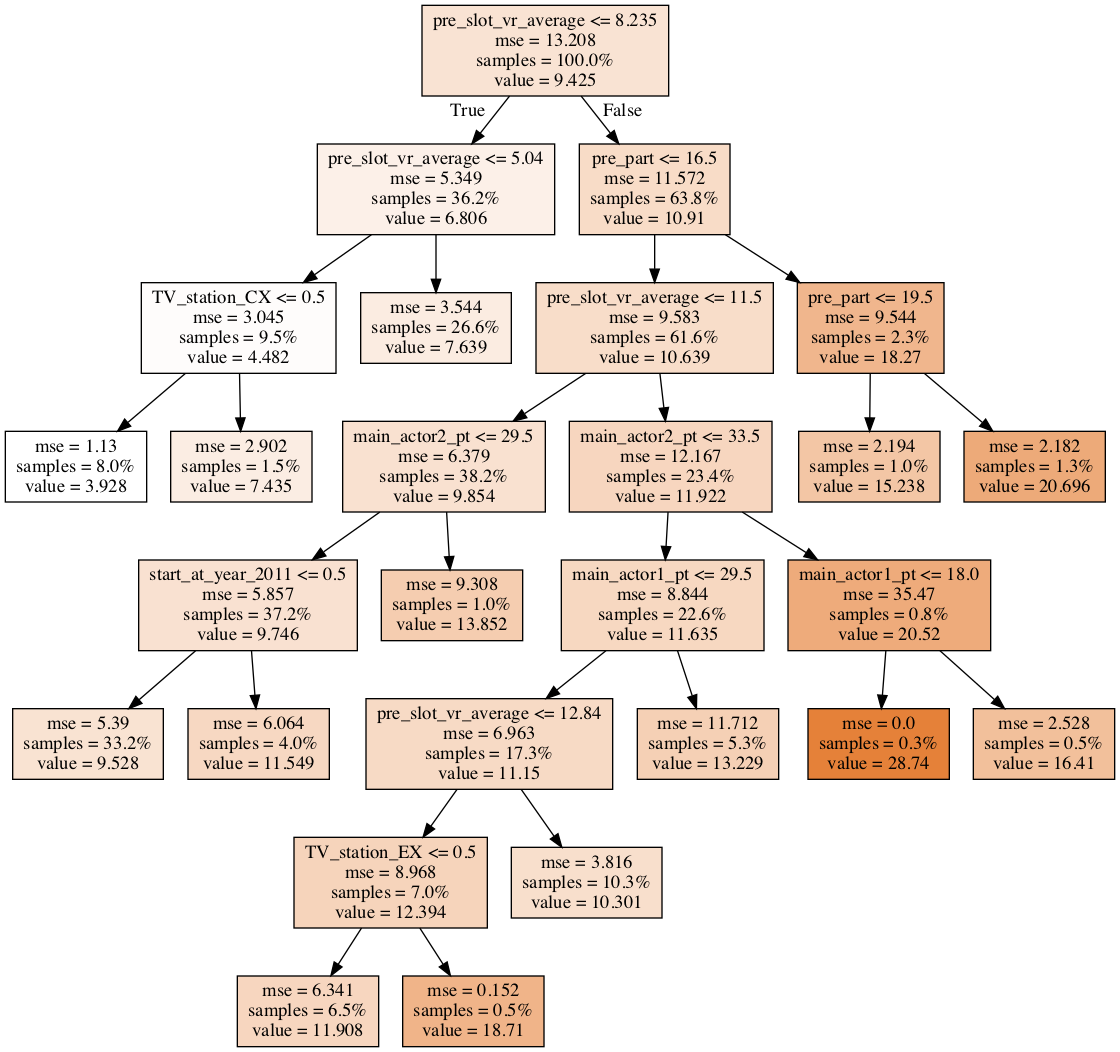

In [84]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names="average",
    filled=True,
    proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [85]:
df_new8years.to_csv("../data/hoge.csv", encoding ="cp932")